# Question 1 (Association)
<br/>

Download the list of transactions by each property agent from https://data.gov.sg/dataset/cea-salesperson-residential-transaction-record, and focus on <b>HDB resale flat transactions where a property agent represented the seller</b>.

<br/>
Task 1: Examine the distribution for <b>number of sales closed by an agent in a year</b> & suggest a
probability distribution that may be suitable for modelling this set of values. What are some
ways in which your suggested distribution is appropriate? What are some of its limitations?

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, norm
import numpy as np
import plotly.graph_objects as go

In [42]:
csv_file_path = "data/CEASalespersonsPropertyTransactionRecordsresidential.csv"
original_df = pd.read_csv(csv_file_path)
original_df

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location
0,SOH HUI HUA,OCT-2017,P000003I,HDB,RESALE,SELLER,YISHUN,-,-
1,SOH HUI HUA,MAR-2018,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,-,-
2,SOH HUI HUA,JAN-2017,P000003I,HDB,RESALE,BUYER,YISHUN,-,-
3,SOH HUI HUA,MAY-2018,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-
4,SOH HUI HUA,NOV-2017,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-
...,...,...,...,...,...,...,...,...,...
954201,-,FEB-2020,-,HDB,ROOM RENTAL,TENANT,TOA PAYOH,12,Balestier/ Toa Payoh/ Serangoon
954202,-,FEB-2020,-,HDB,ROOM RENTAL,LANDLORD,QUEENSTOWN,10,Ardmore/ Bukit Timah/ Holland Road/ Tanglin
954203,-,JAN-2020,-,CONDOMINIUM_APARTMENTS,WHOLE RENTAL,TENANT,-,11,Watten Estate/ Novena/ Thomson
954204,-,FEB-2020,-,CONDOMINIUM_APARTMENTS,WHOLE RENTAL,LANDLORD,-,23,Hillview/ Dairy Farm/ Bukit Panjang/ Choa Chu ...


## Data Cleaning

In [41]:
# Automatically assign the most frequent ID to all inconsistent rows
def most_frequent_id(group):
    return group.value_counts().idxmax()



# Function to check if all non-null values in salesperson_name matches salesperson_reg_num
def checkNamesMatchID(dataframe: pd.DataFrame) -> None:
    inconsistent_df = dataframe.copy()
    # Group by name and get unique IDs
    grouped = inconsistent_df.groupby('salesperson_name')['salesperson_reg_num'].nunique()
    
    # Check for inconsistencies
    inconsistent_names = grouped[grouped > 1].index.tolist()

    if inconsistent_names:
        print(f"Inconsistent IDs found for the following names: {inconsistent_names}")
    else:
        print("All names have consistent unique IDs.")


# Clean dataframe for missing ID values
def cleanDF(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Group by name and get unique IDs
    grouped = dataframe.groupby('salesperson_name')['salesperson_reg_num'].nunique()
    
    # Check for inconsistencies
    inconsistent_names = grouped[grouped > 1].index.tolist()
    
    if inconsistent_names:
        # Create a mapping of names to their most frequent unique ID
        id_mapping = dataframe.groupby('salesperson_name')['salesperson_reg_num'].apply(most_frequent_id).to_dict()
        
        # Update the DataFrame with the most frequent unique ID for each name
        dataframe['salesperson_reg_num'] = dataframe['salesperson_name'].map(id_mapping)
    

    return dataframe

In [44]:
# Check if ID matches names
checkNamesMatchID(original_df)
cleaned_df = cleanDF(original_df)

# Sanity check
checkNamesMatchID(cleaned_df)
cleaned_df

All names have consistent unique IDs.
All names have consistent unique IDs.


,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location
0,SOH HUI HUA,OCT-2017,P000003I,HDB,RESALE,SELLER,YISHUN,-,-
1,SOH HUI HUA,MAR-2018,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,-,-
2,SOH HUI HUA,JAN-2017,P000003I,HDB,RESALE,BUYER,YISHUN,-,-
3,SOH HUI HUA,MAY-2018,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-
4,SOH HUI HUA,NOV-2017,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-
...,...,...,...,...,...,...,...,...,...
954201,-,FEB-2020,-,HDB,ROOM RENTAL,TENANT,TOA PAYOH,12,Balestier/ Toa Payoh/ Serangoon
954202,-,FEB-2020,-,HDB,ROOM RENTAL,LANDLORD,QUEENSTOWN,10,Ardmore/ Bukit Timah/ Holland Road/ Tanglin
954203,-,JAN-2020,-,CONDOMINIUM_APARTMENTS,WHOLE RENTAL,TENANT,-,11,Watten Estate/ Novena/ Thomson
954204,-,FEB-2020,-,CONDOMINIUM_APARTMENTS,WHOLE RENTAL,LANDLORD,-,23,Hillview/ Dairy Farm/ Bukit Panjang/ Choa Chu ...


## Focus on HDB resale flat transactions where a property agent represented the seller

In [68]:
def preprocess_df(dataframe: pd.DataFrame) -> pd.DataFrame:
    hdb_df = dataframe[dataframe['property_type'] == "HDB"]
    resale_hdb_df = hdb_df[hdb_df['transaction_type'] == "RESALE"]
    seller_rep_df = resale_hdb_df[resale_hdb_df['represented'] == 'SELLER']

    # Remove those without ID / names
    seller_rep_df = seller_rep_df[seller_rep_df['salesperson_name'] != "-"]
    final_df = seller_rep_df[seller_rep_df['salesperson_reg_num'] != "-"]
    

    # Parse the 'Date' column to a datetime object
    final_df['ParsedDate'] = pd.to_datetime(final_df['transaction_date'], format='%b-%Y')
    
    # Extract month and year as separate columns
    final_df['year'] = final_df['ParsedDate'].dt.year
    final_df['month'] = final_df['ParsedDate'].dt.month

    
    # Drop columns that has no meaning (i.e general_location, district)
    ## the new preprocessed dataframe will have the same values in columns - 'property_type', 'transaction_type', 'represented' 
    ## dataframe['district'].value_counts() & dataframe['general_location'].value_counts() has been done and all values are '-'
    drop_cols = ['property_type', 'transaction_type', 'represented', 'general_location', 'district', 'ParsedDate']
    final_df = final_df.drop(drop_cols, axis=1)

    return final_df.reset_index(drop=True)

In [69]:
preprocessed_df = preprocess_df(cleaned_df)
preprocessed_df

,salesperson_name,transaction_date,salesperson_reg_num,town,year,month
0,SOH HUI HUA,OCT-2017,P000003I,YISHUN,2017,10
1,SOH HUI HUA,MAY-2018,P000003I,CHOA CHU KANG,2018,5
2,SOH HUI HUA,NOV-2017,P000003I,CHOA CHU KANG,2017,11
3,SOH HUI HUA,AUG-2018,P000003I,SEMBAWANG,2018,8
4,SOH HUI HUA,AUG-2018,P000003I,JURONG WEST,2018,8
...,...,...,...,...,...,...
173366,"LIM JIA CHIN, MARCUS",JUL-2024,R069081A,BEDOK,2024,7
173367,CH NG CHOO YEANG,JUL-2024,R069282Z,SENGKANG,2024,7
173368,LYDIA IZZATI BINTE JASMANI,JUL-2024,R069838D,SEMBAWANG,2024,7
173369,CHEONG FONG ENG,JUL-2024,R070098A,CHOA CHU KANG,2024,7


## Examine the distribution for number of sales closed by an agent in a year

In [108]:
def groupedDF(df: pd.DataFrame):
    grouped_df = df.groupby(by=["month", 'year']).size().reset_index(name="num_sales")
    grouped_df = grouped_df.sort_values(by=['year', 'month']).reset_index(drop=True)
    return grouped_df

sales_count = groupedDF(preprocessed_df)
sales_count

,month,year,num_sales
0,1,2017,1400
1,2,2017,1510
2,3,2017,1375
3,4,2017,1465
4,5,2017,1617
...,...,...,...
86,3,2024,2261
87,4,2024,2343
88,5,2024,2316
89,6,2024,1907


## Data Visualization

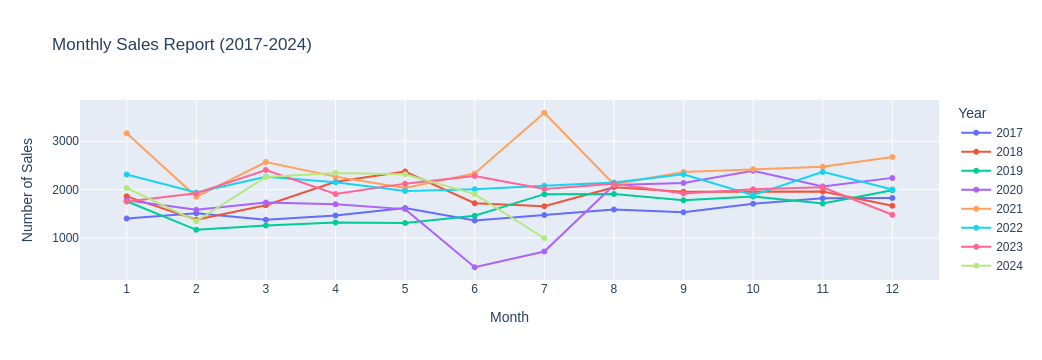

In [117]:
# Interactive Data Visualization

fig = go.Figure()

# Add traces for each year
years = sales_count['year'].unique()
for year in years:
    year_data = sales_count[sales_count['year'] == year]
    fig.add_trace(go.Scatter(x=year_data['month'], y=year_data['num_sales'], mode='lines+markers', name=str(year)))

fig.update_layout(
    title='Monthly Sales Report (2017-2024)',
    xaxis_title='Month',
    yaxis_title='Number of Sales',
    xaxis=dict(tickvals=list(range(1, 13)), ticktext=[str(i) for i in range(1, 13)]),  # Set ticks for each month
    legend_title='Year',
    hovermode='x'  # Show hover information for each point
)


fig.show()

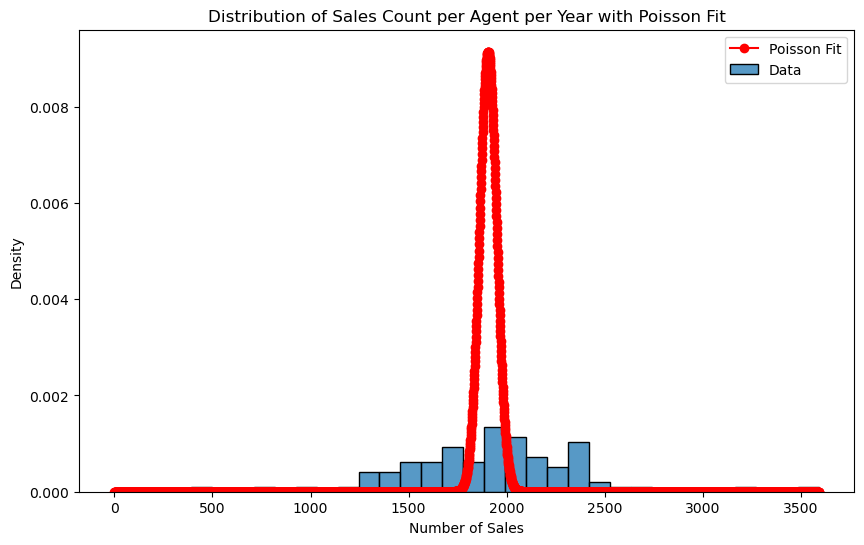

In [114]:
from scipy.stats import poisson

# Fit a Poisson distribution
mu = sales_count['num_sales'].mean()
poisson_dist = poisson(mu)

# Generate Poisson distribution PMF values
x = range(0, sales_count['num_sales'].max() + 1)
poisson_pmf = poisson_dist.pmf(x)

# Plot the Poisson distribution over the histogram
plt.figure(figsize=(10, 6))
sns.histplot(sales_count['num_sales'], bins=30, kde=False, stat='density', label='Data')
plt.plot(x, poisson_pmf, 'o-', label='Poisson Fit', color='red')
plt.title('Distribution of Sales Count per Agent per Year with Poisson Fit')
plt.xlabel('Number of Sales')
plt.ylabel('Density')
plt.legend()
plt.show()


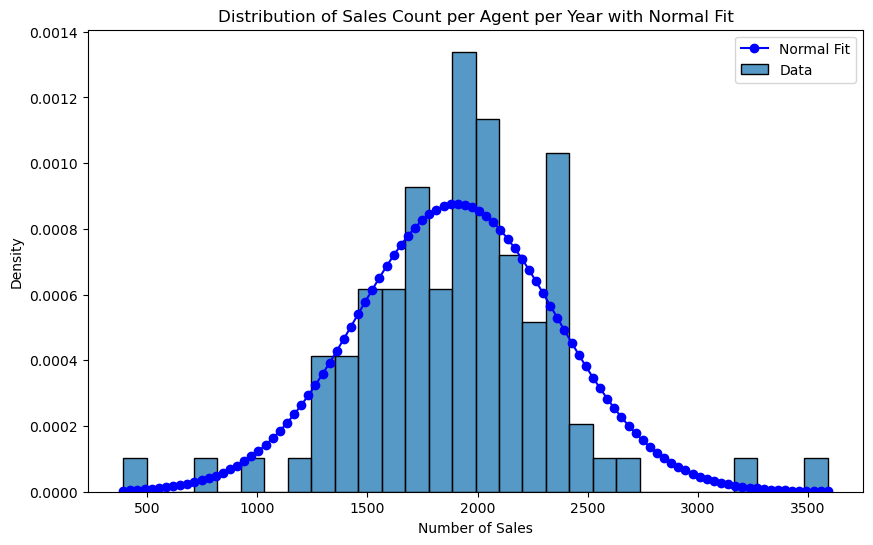

In [115]:
from scipy.stats import norm

# Fit a Normal distribution
mu_norm, std_norm = norm.fit(sales_count['num_sales'])
norm_dist = norm(mu_norm, std_norm)
x = np.linspace(sales_count['num_sales'].min(), sales_count['num_sales'].max(), 100)
norm_pdf = norm_dist.pdf(x)

# Plot the Normal distribution over the histogram
plt.figure(figsize=(10, 6))
sns.histplot(sales_count['num_sales'], bins=30, kde=False, stat='density', label='Data')
plt.plot(x, norm_pdf, 'o-', label='Normal Fit', color='blue')
plt.title('Distribution of Sales Count per Agent per Year with Normal Fit')
plt.xlabel('Number of Sales')
plt.ylabel('Density')
plt.legend()
plt.show()


In [121]:
from scipy.stats import kstest

# Perform Kolmogorov-Smirnov test for Poisson distribution
ks_poisson = kstest(sales_count['num_sales'], poisson_dist.cdf)
print("K-S test for Poisson distribution:", ks_poisson)

# Perform Kolmogorov-Smirnov test for Normal distribution
ks_norm = kstest(sales_count['num_sales'], norm_dist.cdf)
print("K-S test for Normal distribution:", ks_norm)

K-S test for Poisson distribution: KstestResult(statistic=0.4135626696189545, pvalue=1.3352079130585212e-14, statistic_location=2000, statistic_sign=-1)
K-S test for Normal distribution: KstestResult(statistic=0.07404347344095863, pvalue=0.6727722005645043, statistic_location=2420, statistic_sign=1)


## Conclusion

Since p-value for Normal Distribution is significantly large than that for Poisson Distribution, there is not enough evidence from the data to reject the null hypothesis that the data does not follow Normal Distribution.

<br/>

Hence, the data may be approximated to follow a Normal Distribution.